In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None # 역전파 계산 때 사용할 x, h_prev, h_next 담음

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        # h_t
        t = np.matmul(h_prev,Wh) + np.matmul(x, Wx) + b
        # tahn
        h_next = np.tahn(t)
        # 데이터 저장
        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

In [1]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        '''
        초기화 인수 : 가중치, 편향, stateful(True일 때, 은닉 상태 유지/이전 h 인계-순전파)
                                           (False일 때, 은닉 상태를 영행렬로 초기화)
        인스턴스 변수 : layers, h(forward 은닉 상태 보관/인계), dh
                              - h: forward() 메서드를 불렀을 때 마지막 RNN 계층의 은닉 상태를 저장
                              - dh: backward()를 불렀을 때 하나 앞 블록의 은닉 상태의 기울기를 저장한다.
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None # recurrent
        self.stateful = stateful

    # 은닉 상태 설정
    def set_state(self, h):
        self.h = h

    # 은닉 상태 초기화
    def reset_state(self):
        self.h = None

    def forward(self, xs): # xs는 T개 분량의 시계열 데이터를 하나로 모은 것
        Wx, Wh, b = self.params
        N, T, D = xs.shape # (미니배치, T개 시계열, 입력벡터차원)
        D, H = Wx.shape # (입력벡터차원, hidden)
        
        self.layers = []
        # 출력값 담을 그릇! = 입력xs shape
        hs = np.empty((N, T, H), dtype='f') # 32bit

        if not self.stateful or self.h is None: # 은닉상태유지x거나 처음 초기화
            self.h = np.zeros((N, H), dtype='f')

        # Recurrent Neural Network 생성 : 각 t 시점에서 은닉 상태 계산
        for t in range(T):
            layer = RNN(*self.params) # 초기화 인수 (Wx, Wh, b)
            self.h = layer.forward(xs[:, t, :], self.h) # 인수 (x, h_prev)
            hs[:, t, :] = self.h # 출력값
            self.layers.append(layer) # 저장!

        return hs 

    def backward(self, dhs): # hs는 출력값
        Wx, Wh, b = self.params
        N, T, H = dhs.shape # 출력
        D, H = Wx.shape # (input, hidden)

        # 하류로 흘려보낼 xs 기울기 그릇!
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0 # 이전 시각 hidden state 기울기, Truncated BPTT
        grads = [0, 0, 0] # Truncated BPTT

        # RNN 계층 역전파 시작
        for t in reversed(range(T)):
            layer = self.layer[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) # 합산된 기울기, dh는 그냥 저장용
            dxs[:, t, :] = dx # 하류로 흘려보낼 마지막 역전파 결과

            for i, grad in enuerate(layer.grads):
                grads[i] = grad

        # self.grads에 저장
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad        
        self.dh = dh # 저장용
            
        return dxs

In [2]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        # T개의 Affine 계층 각각 계산 -> 행렬로 한번에!
        N, T, D = x.shape
        W, b = self.params
        # x = (N,T,D) -> (N*T,D) 2차원 dot위해
        rx = x.reshape(N*T, -1)
        # affine
        out = np.dot(rx, W) + b
        self.x = x # 역전파 때
        # 다시 (N,T,D)
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [ ]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts): # logit, label
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우 (N,T,V)
            ts = ts.argmax(axis=2) # 정답 인덱스로

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 1. 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f') # 0.01
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 2. 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), # Truncated BPTT
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1] # TimeRNN

        # 3. 모든 가중치와 기울기를 리스트에 모은다
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.parmas
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state() # TimeRNN reset hidden(self.h)


말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 396.74
| 에폭 2 | 퍼플렉서티 268.22
| 에폭 3 | 퍼플렉서티 225.05
| 에폭 4 | 퍼플렉서티 215.87
| 에폭 5 | 퍼플렉서티 207.27
| 에폭 6 | 퍼플렉서티 202.53
| 에폭 7 | 퍼플렉서티 198.56
| 에폭 8 | 퍼플렉서티 196.67
| 에폭 9 | 퍼플렉서티 191.39
| 에폭 10 | 퍼플렉서티 193.00
| 에폭 11 | 퍼플렉서티 188.86
| 에폭 12 | 퍼플렉서티 192.83
| 에폭 13 | 퍼플렉서티 190.53
| 에폭 14 | 퍼플렉서티 190.37
| 에폭 15 | 퍼플렉서티 189.79
| 에폭 16 | 퍼플렉서티 185.86
| 에폭 17 | 퍼플렉서티 183.32
| 에폭 18 | 퍼플렉서티 180.49
| 에폭 19 | 퍼플렉서티 181.37
| 에폭 20 | 퍼플렉서티 184.51
| 에폭 21 | 퍼플렉서티 180.65
| 에폭 22 | 퍼플렉서티 177.53
| 에폭 23 | 퍼플렉서티 173.03
| 에폭 24 | 퍼플렉서티 174.83
| 에폭 25 | 퍼플렉서티 172.83
| 에폭 26 | 퍼플렉서티 172.18
| 에폭 27 | 퍼플렉서티 167.48
| 에폭 28 | 퍼플렉서티 168.35
| 에폭 29 | 퍼플렉서티 165.35
| 에폭 30 | 퍼플렉서티 157.95
| 에폭 31 | 퍼플렉서티 159.69
| 에폭 32 | 퍼플렉서티 154.00
| 에폭 33 | 퍼플렉서티 154.31
| 에폭 34 | 퍼플렉서티 150.06
| 에폭 35 | 퍼플렉서티 146.71
| 에폭 36 | 퍼플렉서티 141.73
| 에폭 37 | 퍼플렉서티 137.18
| 에폭 38 | 퍼플렉서티 132.83
| 에폭 39 | 퍼플렉서티 130.80
| 에폭 40 | 퍼플렉서티 125.50
| 에폭 41 | 퍼플렉서티 124.60
| 에폭 42 | 퍼플렉서티 117.27
| 에폭 43 | 퍼플렉서티 110

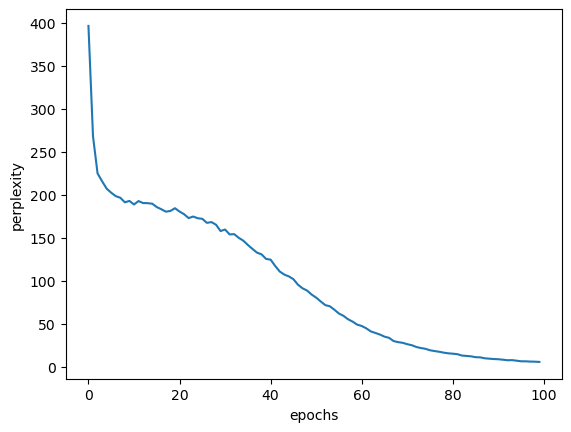

In [26]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

# 1. 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 히든 벡터의 원소 수
time_size = 5 # Truncated BPTT, 각 배치당 한 묶음 안 원소 개수수
lr = 0.1
max_epoch = 100

# 2. 학습 데이터 읽기(전체 중 1000개 단어만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size] # 단어 1000개 (1000,)
vocab_size = int(max(corpus) + 1) # id 인덱스 0부터 시작하니까까

xs = corpus[:-1] # 입력 (999,)
ts = corpus[1:]  # 출력(정답 레이블) (999,) -> 하나 shift!!
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 3. 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size) # 정수, 소수점 이하 버림
# 배치크기x시각길이는 "한 블럭","1 iter당 원소 수", 1단계 timernn, t단계 rnn
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 4. 모델 생성 & optimizer
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 5. train!
# (1) 각 미니배치에서 Truncated BPTT 샘플(데이터)을 읽는 시작 위치를 조정 -> offsets
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)] # 배치(jump)만큼 뜀

for epoch in range(max_epoch):
    for iter in range(max_iters): # 1에폭만큼
        # (2) 미니배치 획득 - 그릇 준비 후
        batch_x = np.empty((batch_size, time_size), dtype='i') # int
        batch_t = np.empty((batch_size, time_size), dtype='i')

        for t in range(time_size): # time_size만큼 원소들 채워넣기
            for i, offset in enumerate(offsets): # 배치1부터~batch_size만큼
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # (3) 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # (4) 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count) # 1에폭마다의!! 평균!
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

In [2]:
xs.shape

(999,)

In [4]:
ts.shape

(999,)

In [6]:
corpus.shape

(1000,)

In [23]:
import numpy as np
x = np.random.randn(9)
batch_size = 3
data_size = len(x) 
jump = data_size // batch_size  
offsets = [i * jump for i in range(batch_size)]
offsets

[0, 3, 6]

In [25]:
time_idx = 0
time_size = 2
x = np.random.random(9)
t = np.random.random(9)
batch_x = np.empty((batch_size, time_size), dtype='i')
batch_t = np.empty((batch_size, time_size), dtype='i')
for time in range(time_size): # 배치 내에서 time만큼 끊어야 됨
    for i, offset in enumerate(offsets): # 0 500
            print((offset + time_idx) % data_size)
            batch_x[i, time] = x[(offset + time_idx) % data_size]
            batch_t[i, time] = t[(offset + time_idx) % data_size]
    time_idx += 1

0
3
6
1
4
7


In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm
from common.trainer import RnnlmTrainer

# 1. 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 히든 벡터의 원소 수
time_size = 5 # Truncated BPTT, 각 배치당 한 묶음 안 원소 개수수
lr = 0.1
max_epoch = 100

# 2. 학습 데이터 읽기(전체 중 1000개 단어만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size] # 단어 1000개만!! (0~999)
vocab_size = int(max(corpus) + 1) # id 인덱스 0부터 시작하니까, size는 1부터 개수 세야..

xs = corpus[:-1] # 입력 (999,)
ts = corpus[1:]  # 출력(정답 레이블) (999,) -> 하나 shift!!
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 3. 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size) # 정수, 소수점 이하 버림
# 배치크기x시각길이는 "한 블럭","1 iter당 원소 수", 1단계 timernn, t단계 rnn
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 4. 모델 생성 & optimizer
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 5. train!
trainer.fit(xs, ts, max_epoch, batch_size, time_size)

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.78
| 에폭 2 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 380.30
| 에폭 3 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 260.42
| 에폭 4 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 221.85
| 에폭 5 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 210.52
| 에폭 6 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 208.26
| 에폭 7 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 201.58
| 에폭 8 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 201.92
| 에폭 9 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 195.85
| 에폭 10 |  반복 1 / 19 | 시간 4[s] | 퍼플렉서티 190.97
| 에폭 11 |  반복 1 / 19 | 시간 5[s] | 퍼플렉서티 192.89
| 에폭 12 |  반복 1 / 19 | 시간 6[s] | 퍼플렉서티 189.47
| 에폭 13 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 194.26
| 에폭 14 |  반복 1 / 19 | 시간 7[s] | 퍼플렉서티 188.48
| 에폭 15 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 187.96
| 에폭 16 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 191.51
| 에폭 17 |  반복 1 / 19 | 시간 8[s] | 퍼플렉서티 190.10
| 에폭 18 |  반복 1 / 19 | 시간 9[s] | 퍼플렉서티 185.90
| 에폭 19 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 181.91
| 에폭 20 |  반복 1 / 19 | 시간 10[s] | 퍼플렉서티 181.96
| 에폭 21 |  반복 1 / 19 | 시간 11[s] | 퍼플렉서티 179.96
| 에폭 22 |  반복 1 

In [2]:
corpus[0]

0

이 코드 조각은 신경망에서 이진 분류 문제를 처리하기 위해 사용되는 손실 함수를 설정하는 부분입니다. `cross_entropy_error`는 교차 엔트로피 오차를 계산하는 함수이며, 이진 분류에서 널리 사용됩니다.

이 코드에서 `self.y`는 모델의 출력, 즉 예측 확률을 나타냅니다. 이진 분류에서는 일반적으로 모델의 출력이 하나의 값(`self.y`)으로 주어지며, 이 값은 특정 클래스(예: 긍정 클래스)에 속할 확률을 나타냅니다. 따라서, 다른 클래스(예: 부정 클래스)에 속할 확률은 `1 - self.y`로 계산할 수 있습니다.

`np.c_[1 - self.y, self.y]`는 모델의 예측을 두 클래스에 대한 확률 분포로 변환합니다. 첫 번째 열(`1 - self.y`)은 부정 클래스에 대한 확률을, 두 번째 열(`self.y`)은 긍정 클래스에 대한 확률을 나타냅니다. 이렇게 변환된 확률 분포는 교차 엔트로피 오차를 계산하는 데 사용됩니다.

`self.t`는 실제 타겟 레이블을 나타냅니다. 이진 분류에서는 일반적으로 `[1, 0]` 또는 `[0, 1]`과 같은 방식으로 타겟 클래스를 원-핫 인코딩 형태로 표현합니다. 여기서 `[1, 0]`은 첫 번째 클래스(부정 클래스)가 정답임을, `[0, 1]`은 두 번째 클래스(긍정 클래스)가 정답임을 나타냅니다.

따라서, `cross_entropy_error(np.c_[1 - self.y, self.y], self.t)` 코드는 예측 확률 분포와 실제 타겟 분포 사이의 교차 엔트로피 오차를 계산하여, 모델의 손실을 계산합니다. 이 손실 값은 모델 학습 과정에서 최소화되어야 할 대상입니다.

이 방식은 특히 로지스틱 회귀나 신경망에서 이진 분류를 수행할 때 흔히 사용되는 방법입니다. 모델이 두 클래스 간의 확률을 효과적으로 예측하도록 학습하는 것을 목표로 합니다.